## Configuration (Change these to create different plots)

In [18]:
NUM_COMPONENTS = 2  # 2 for 2D plots, 3 for 3D plots
NUM_SAMPLES = 700  # How many samples to read from each IQ file

# USAGE:
# PLOT_TEAM_X_MODEL: True or False
# PARAMS_TO_PLOT_TX: A list of 0 or more strings from ['bandwidth', 'cent_freq', 'obs_int', 'sig_type', 'snr']
# LAYERS_TO_PLOT_TX: A list of strings corresponding to the Fully Connected layers to extract features from. Number of layers changes depending on model
# BANDWIDTHS_TX: List of floats corresponding to the bandwidths you want to plot, or the string 'all'
# CENT_FREQS_TX: List of floats corresponding to the center frequencies you want to plot, or the string 'all'
# OBS_INTS_TX: List of ints corresponding to the observation lengths you want to plot, or the string 'all'
# SIG_TYPES_TX: List of strings corresponding to the signal types you want to plot, or the string 'all'
# SNRS_TX: List of ints corresponding to the signal-to-noise ratios you want to plot, or the string 'all'

# Team 1
PLOT_TEAM_1_MODEL = True
PARAMS_TO_PLOT_T1 = ['snr']
LAYERS_TO_PLOT_T1 = ['fc1']  # May be any layers from 'fc1', 'fc2', 'fc3', 'fc4'
BANDWIDTHS_T1 = [0.5]
CENT_FREQS_T1 = [0.5]
OBS_INTS_T1 = [2048]
SIG_TYPES_T1 = 'all'
SNRS_T1 = [5, 10, 14]

# Team 2
PLOT_TEAM_2_MODEL = False
PARAMS_TO_PLOT_T2 = ['bandwidth', 'cent_freq', 'obs_int', 'snr']
LAYERS_TO_PLOT_T2 = ['fc1']  # May be any layers from 'fc1', 'fc2'
BANDWIDTHS_T2 = [0.5]
CENT_FREQS_T2 = [0.5]
OBS_INTS_T2 = [2048]
SIG_TYPES_T2 = 'all'
SNRS_T2 = [14]

# Team 3
PLOT_TEAM_3_MODEL = False
PARAMS_TO_PLOT_T3 = ['bandwidth', 'cent_freq', 'obs_int', 'snr']
LAYERS_TO_PLOT_T3 = ['fc1', 'fc2', 'fc3']  # May be any layers from 'fc1', 'fc2', 'fc3', 'fc4'
BANDWIDTHS_T3 = [0.5]
CENT_FREQS_T3 = [0.5]
OBS_INTS_T3 = [2048]
SIG_TYPES_T3 = []
SNRS_T3 = [14]

# Team 4
PLOT_TEAM_4_MODEL = False
PARAMS_TO_PLOT_T4 = ['bandwidth', 'cent_freq', 'obs_int', 'sig_type', 'snr']
LAYERS_TO_PLOT_T4 = ['fc1', 'fc2']   # May be any layers from 'fc1', 'fc2', 'fc3'
BANDWIDTHS_T4 = [0.05, 0.2525, 0.5]
CENT_FREQS_T4 = [0.1, 0.26, 0.5]
OBS_INTS_T4 = [256, 1024, 2048]
SIG_TYPES_T4 = 'all'
SNRS_T4 = [5, 10, 14]

## Import Modules

In [19]:
#!pip3 install plotly

import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#os.environ["WORLD_SIZE"] = "1"
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from tqdm import tqdm
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
import plotly.graph_objects as go

print('Cuda available:', torch.cuda.is_available())

%matplotlib inline

Cuda available: True


## Model setup

In [20]:
class Team1Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(2, 16))
        self.pool = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(1, 8))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 8))
        #self.fc1 = nn.Linear(in_features=15360, out_features=1200)  # Fully Connected Layer
        self.fc1 = nn.LazyLinear(out_features=1200)
        self.fc2 = nn.Linear(in_features=1200, out_features=100)
        self.fc3 = nn.Linear(in_features=100, out_features=65)
        self.fc4 = nn.Linear(in_features=65, out_features=self.num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        # print(f'after conv1: {x.shape}')
        x = self.pool(x)
        # print(f'after pool: {x.shape}')
        x = F.relu(self.conv2(x))
        # print(f'after conv2: {x.shape}')
        x = self.pool(x)
        # print(f'after pool: {x.shape}')
        x = F.relu(self.conv3(x))
        # print(f'after conv3: {x.shape}')
        x = self.pool(x)
        # print(f'after pool: {x.shape}')
        x = x.reshape(x.shape[0], -1)
        # print(f'after reshaping: {x.shape}')
        x = F.relu(self.fc1(x))
        # print(f'fc1: {x.shape}')
        x = F.relu(self.fc2(x))
        # print(f'fc2: {x.shape}')
        x = F.relu(self.fc3(x))
        # print(f'fc3: {x.shape}')
        #x = F.relu(self.fc4(x))
        x = self.fc4(x)
        # print(f'fc3: {x.shape}')

        return x

In [21]:
class Team2Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(2, 128, 8, dtype=torch.float32),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.BatchNorm1d(128),
            nn.Conv1d(128, 256, 8, dtype=torch.float32),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.BatchNorm1d(256),
            nn.Conv1d(256, 512, 8, dtype=torch.float32),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.BatchNorm1d(512),
            nn.Conv1d(512, 1024, 8, dtype=torch.float32),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.BatchNorm1d(1024),
        )

        self.fc1 = nn.LazyLinear(512, dtype=torch.float32)
        self.fc2 = nn.Linear(512, num_classes, dtype=torch.float32)
        # self.fc = nn.Sequential(
        #     nn.LazyLinear(512, dtype=torch.float32),
        #     nn.ReLU(),
        #     nn.Linear(512, num_classes, dtype=torch.float32),
        #     nn.ReLU(),
        # )

    def forward(self, x):
        x = x.squeeze(1)
        for layer in self.conv_layers:
            x = layer(x)
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc2(x)
        #return F.softmax(x, dim=1)
        return x

In [22]:
# From headley_modrec.py
class Team3Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(1, 16, (2, 16))
        self.conv2 = nn.Conv2d(16, 8, (1, 8))
        self.conv3 = nn.Conv2d(8, 4, (1, 4))
        #self.fc1 = nn.Linear(3996, 512)
        self.fc1 = nn.LazyLinear(out_features=512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, self.num_classes)

        self.activation = {}

    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = F.tanh(self.conv2(x))
        x = F.tanh(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [23]:
class Team4Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.re1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.re2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.re3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.re4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))

        self.flat = nn.Flatten()
        self.drop1 = nn.Dropout(0.5)
        #self.fc1 = nn.Linear(128 * 256,512)  # I dont exactly know why it is 128x256, but I had to do some debugging and hardcode the required value
        self.fc1 = nn.LazyLinear(out_features=512)

        self.re5 = nn.ReLU()
        self.drop2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.re6 = nn.ReLU()
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(self.re1(self.conv1(x)))
        x = self.pool2(self.re2(self.conv2(x)))
        x = self.pool3(self.re3(self.conv3(x)))
        x = self.pool4(self.re4(self.conv4(x)))
        x = self.flat(x)
        x = self.drop1(x)
        x = self.re5(self.fc1(x))
        x = self.drop2(x)
        x = self.re6(self.fc2(x))
        x = self.fc3(x)
        return x

## Script setup

In [25]:
# Constants
CHUNK_SIZE = 5000
MODELS_OBS_INT = 2048
TEAM_1_OBS_INT = 2048
TEAM_2_OBS_INT = 1024
TEAM_3_OBS_INT = 512
TEAM_4_OBS_INT = 256

MARKER_MIN_SIZE = 5
MARKER_MAX_SIZE = 15

# Name, [modulation type, num symbols], class label
sig_types = [['2-ASK', ['ask', 2], 0],
             ['4-ASK', ['ask', 4], 1],
             ['8-ASK', ['ask', 8], 2],
             ['BPSK', ['psk', 2], 3],
             ['QPSK', ['psk', 4], 4],
             ['16-QAM', ['qam', 16], 5],
             ['Tone', ['constant'], 6],
             ['P-FMCW', ['p_fmcw'], 7]]
num_classes = len(sig_types)
target_names = [x[0] for x in sig_types]

colors = ['Blue', 'Orange', 'Green', 'Red', 'Purple', 'Brown', px.colors.qualitative.Plotly[6], 'Gray']

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

team1_model = Team1Model(num_classes)
team1_model.load_state_dict(torch.load('../data/summer_models/team1_model.pt', map_location=torch.device('cpu')))
team1_model.eval()

team2_model = Team2Model(num_classes)
team2_model.load_state_dict(torch.load('../data/summer_models/team2_model.pt', map_location=torch.device('cpu')))
team2_model.eval()

team3_model = Team3Model(num_classes)
team3_model.load_state_dict(torch.load('../data/summer_models/team3_model.pt', map_location=torch.device('cpu')))
team3_model.eval()

team4_model = Team4Model(num_classes)
team4_model.load_state_dict(torch.load('../data/summer_models/team4_model.pt', map_location=torch.device('cpu')))
team4_model.eval()

team1_test_dir = os.path.join('../data/summer_data', 'team1', 'test')
team2_test_dir = os.path.join('../data//summer_data', 'team2', 'test')
team3_test_dir = os.path.join('../data/summer_data', 'team3', 'test')
team4_test_dir = os.path.join('../data/summer_data', 'team4', 'test')
print('done')

cuda


/tmp/ipykernel_1961/1506016634.py:30: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



done


/tmp/ipykernel_1961/1506016634.py:34: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_1961/1506016634.py:38: FutureWarning:

You are using `torch.load` with `we

## Data loading, feature extraction, and plotting functions

In [26]:
def load_data(channel_path, batch_size, num_batches, num_train_examples, data_obs_int):
    training_data = np.zeros((num_train_examples, 1, 2, MODELS_OBS_INT), dtype=np.float32)
    training_labels = np.zeros((num_train_examples, num_classes), dtype=np.float32)

    last_index = 0
    for k in range(num_batches):
        # This is used if we have a labeldata folder that stores class labels
        label_df = pd.read_csv(f"{channel_path}/labeldata/example_{k + 1}.csv")

        iq_data = np.fromfile(f"{channel_path}/iqdata/example_{k + 1}.dat", np.csingle)
        iq_data = np.reshape(iq_data, (-1, data_obs_int))  # Turn the IQ data into chunks of (chunk size) x (data_obs_int)
        for j in range(iq_data.shape[0]):
            iq_array_norm = iq_data[j][:] / np.max(np.abs(iq_data[j][:]))  # Normalize the observation
            iq_array = np.vstack((iq_array_norm.real, iq_array_norm.imag))  # Separate into 2 subarrays - 1 with only real (in-phase), the other only imaginary (quadrature)

            # Pad the iq array with zeros to meet the observation length requirement
            # This is needed because the CNN models have a fixed input size
            iq_array = np.pad(iq_array, ((0, 0), (0, MODELS_OBS_INT - iq_array[0].size)), mode='constant', constant_values=0)

            training_data[last_index, 0, :, :] = iq_array
            training_labels[last_index, label_df.iloc[j]] = 1.0
            last_index += 1

    return torch.utils.data.DataLoader([[training_data[i], training_labels[i]] for i in range(num_train_examples)], batch_size=batch_size, shuffle=False)


def plot_snr_feats(model, target_layer, target_snrs, test_dir, data_obs_int, title):
    # Helper function for extracting features from the model
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()

        return hook

    snr_dir = os.path.join(test_dir, 'snr')
    snr_folder_names = []
    min_snr = 0  # Placeholder values
    max_snr = 100

    
    if NUM_COMPONENTS == 2:
        # Each row is (comp1, comp2, marker size)
        x_2_ask = np.empty(shape=[0, 3])
        x_4_ask = np.empty(shape=[0, 3])
        x_8_ask = np.empty(shape=[0, 3])
        x_bpsk = np.empty(shape=[0, 3])
        x_qpsk = np.empty(shape=[0, 3])
        x_16_qam = np.empty(shape=[0, 3])
        x_tone = np.empty(shape=[0, 3])
        x_pfmcw = np.empty(shape=[0, 3])
    else:
        # Each row is (comp1, comp2, comp3, marker size)
        x_2_ask = np.empty(shape=[0, 4])
        x_4_ask = np.empty(shape=[0, 4])
        x_8_ask = np.empty(shape=[0, 4])
        x_bpsk = np.empty(shape=[0, 4])
        x_qpsk = np.empty(shape=[0, 4])
        x_16_qam = np.empty(shape=[0, 4])
        x_tone = np.empty(shape=[0, 4])
        x_pfmcw = np.empty(shape=[0, 4])
    
    

    # Iterate over every folder in the SNR directory
    for path, subdirs, files in os.walk(snr_dir):
        # If we're in the top-level snr directory, get the values from all the folder names
        if os.path.basename(path) == 'snr':
            # Record the names of the folders and the min/max values
            snr_folder_names = subdirs
            if target_snrs == 'all':
                min_snr = min([int(x) for x in snr_folder_names])
                max_snr = max([int(x) for x in snr_folder_names])
            else:
                min_snr = min([int(x) for x in target_snrs])
                max_snr = max([int(x) for x in target_snrs])
        # If we're in one of the SNR directories, process it and add markers to the plot
        elif os.path.basename(path) in snr_folder_names:
            snr = int(os.path.basename(path))

            # If the current directory isn't one of the ones we're targeting, skip it
            if target_snrs != 'all' and snr not in target_snrs:
                continue

            # Load the IQ data in this folder
            snr_iq_files = os.path.join(path, 'iqdata', 'example_1.dat')
            file_list = glob.glob(snr_iq_files)
            num_batches = len(file_list)
            num_examples = num_batches * CHUNK_SIZE
            snr_dataloader = load_data(path, 1, num_batches, num_examples, data_obs_int)

            # Set up the model for feature extraction
            target_layer.register_forward_hook(get_features('feats'))
            model.to(device)
            labels_list = []
            preds_list = []
            feats_list = []
            features = {}

            # Feed the IQ data into the model
            for idx, (inputs, labels) in tqdm(enumerate(snr_dataloader)):
                inputs = inputs.to(device)
                with torch.inference_mode():
                    preds = model(inputs)
                
                # Check if any NaN values were returned
                new_feats = features['feats'].cpu().numpy()
                if np.isnan(new_feats).any():
                    continue

                labels_list.append(labels.numpy())
                preds_list.append(preds.detach().cpu().numpy())
                feats_list.append(features['feats'].cpu().numpy())

                if idx == NUM_SAMPLES:  # Including too many samples can make the plot difficult to read
                    break

            # Convert from lists to numpy arrays
            labels_list = np.concatenate(labels_list)
            preds_list = np.concatenate(preds_list)
            feats_list = np.concatenate(feats_list)

            # Extract features and get data needed for the scatterplot
            pca = PCA(n_components=NUM_COMPONENTS)
            X_pca = pca.fit_transform(feats_list)
            #print(X_pca)
            #y = np.argmax(preds_list, axis=1)  # Color markers based on model predictions
            y = np.argmax(labels_list, axis=1)  # Color markers based on ground truth label
            
            # Append the extracted features for each signal type
            x_2_ask = np.append(x_2_ask, np.pad(X_pca[(y == 0)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(snr, [min_snr, max_snr], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            #print('x_2_ask: ', x_2_ask)
            x_4_ask = np.append(x_4_ask, np.pad(X_pca[(y == 1)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(snr, [min_snr, max_snr], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            #print('x_4_ask: ', x_4_ask)
            x_8_ask = np.append(x_8_ask, np.pad(X_pca[(y == 2)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(snr, [min_snr, max_snr], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            #print('x_8_ask: ', x_8_ask)
            x_bpsk = np.append(x_bpsk, np.pad(X_pca[(y == 3)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(snr, [min_snr, max_snr], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            #print('x_bpsk: ', x_bpsk)
            x_qpsk = np.append(x_qpsk, np.pad(X_pca[(y == 4)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(snr, [min_snr, max_snr], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            #print('x_qpsk: ', x_qpsk)
            x_16_qam = np.append(x_16_qam, np.pad(X_pca[(y == 5)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(snr, [min_snr, max_snr], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            #print('x_16_qam: ', x_16_qam)
            x_tone = np.append(x_tone, np.pad(X_pca[(y == 6)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(snr, [min_snr, max_snr], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            #print(x_tone)
            x_pfmcw = np.append(x_pfmcw, np.pad(X_pca[(y == 7)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(snr, [min_snr, max_snr], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            #print('x_pfmcw: ', x_pfmcw)
    
    add_signals_to_plot([x_2_ask, x_4_ask, x_8_ask, x_bpsk, x_qpsk, x_16_qam, x_tone, x_pfmcw], title)


def plot_bandwidth_feats(model, target_layer, target_bandwidths, test_dir, data_obs_int, title):
    # Helper function for extracting features from the model
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()

        return hook

    bandwidths_dir = os.path.join(test_dir, 'bandwidths')
    bandwidth_folder_names = []
    min_bandwidth = 0  # Placeholder values
    max_bandwidth = 100
    plt.figure(figsize=(8, 8))

    if NUM_COMPONENTS == 2:
        # Each row is (comp1, comp2, marker size)
        x_2_ask = np.empty(shape=[0, 3])
        x_4_ask = np.empty(shape=[0, 3])
        x_8_ask = np.empty(shape=[0, 3])
        x_bpsk = np.empty(shape=[0, 3])
        x_qpsk = np.empty(shape=[0, 3])
        x_16_qam = np.empty(shape=[0, 3])
        x_tone = np.empty(shape=[0, 3])
        x_pfmcw = np.empty(shape=[0, 3])
    else:
        # Each row is (comp1, comp2, comp3, marker size)
        x_2_ask = np.empty(shape=[0, 4])
        x_4_ask = np.empty(shape=[0, 4])
        x_8_ask = np.empty(shape=[0, 4])
        x_bpsk = np.empty(shape=[0, 4])
        x_qpsk = np.empty(shape=[0, 4])
        x_16_qam = np.empty(shape=[0, 4])
        x_tone = np.empty(shape=[0, 4])
        x_pfmcw = np.empty(shape=[0, 4])

    # Iterate over every folder in the bandwidths directory
    for path, subdirs, files in os.walk(bandwidths_dir):
        # If we're in the top-level bandwidths directory, get the values from all the folder names
        if os.path.basename(path) == 'bandwidths':
            # Record the names of the folders and the min/max values
            bandwidth_folder_names = subdirs
            if target_bandwidths == 'all':
                min_bandwidth = min([float(x) for x in bandwidth_folder_names])
                max_bandwidth = max([float(x) for x in bandwidth_folder_names])
            else:
                min_bandwidth = min([float(x) for x in target_bandwidths])
                max_bandwidth = max([float(x) for x in target_bandwidths])
        # If we're in one of the bandwidth directories, process it and add markers to the plot
        elif os.path.basename(path) in bandwidth_folder_names:
            bandwidth = float(os.path.basename(path))

            # If the current directory isn't one of the ones we're targeting, skip it
            if target_bandwidths != 'all' and bandwidth not in target_bandwidths:
                continue

            # Load the IQ data in this folder
            bandwidth_iq_files = os.path.join(path, 'iqdata', 'example_1.dat')
            file_list = glob.glob(bandwidth_iq_files)
            num_batches = len(file_list)
            num_examples = num_batches * CHUNK_SIZE
            bandwidth_dataloader = load_data(path, 1, num_batches, num_examples, data_obs_int)

            # Set up the model for feature extraction
            target_layer.register_forward_hook(get_features('feats'))
            model.to(device)
            preds_list = []
            feats_list = []
            labels_list = []
            features = {}

            # Feed the IQ data into the model
            for idx, (inputs, labels) in tqdm(enumerate(bandwidth_dataloader)):
                inputs = inputs.to(device)
                with torch.inference_mode():
                    preds = model(inputs)
                
                # Check if any NaN values were returned
                new_feats = features['feats'].cpu().numpy()
                if np.isnan(new_feats).any():
                    continue

                labels_list.append(labels.numpy())
                preds_list.append(preds.detach().cpu().numpy())
                feats_list.append(features['feats'].cpu().numpy())

                if idx == NUM_SAMPLES:
                    break

            # Convert from lists to numpy arrays
            labels_list = np.concatenate(labels_list)
            preds_list = np.concatenate(preds_list)
            feats_list = np.concatenate(feats_list)

            # Extract features and get data needed for the scatterplot
            pca = PCA(n_components=NUM_COMPONENTS)
            X_pca = pca.fit_transform(feats_list)
            #y = np.argmax(preds_list, axis=1)  # Color markers based on model predictions
            y = np.argmax(labels_list, axis=1)  # Color markers based on ground truth labels
            
            # Append the extracted features for each signal type
            x_2_ask = np.append(x_2_ask, np.pad(X_pca[(y == 0)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(bandwidth, [min_bandwidth, max_bandwidth], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_4_ask = np.append(x_4_ask, np.pad(X_pca[(y == 1)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(bandwidth, [min_bandwidth, max_bandwidth], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_8_ask = np.append(x_8_ask, np.pad(X_pca[(y == 2)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(bandwidth, [min_bandwidth, max_bandwidth], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_bpsk = np.append(x_bpsk, np.pad(X_pca[(y == 3)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(bandwidth, [min_bandwidth, max_bandwidth], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_qpsk = np.append(x_qpsk, np.pad(X_pca[(y == 4)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(bandwidth, [min_bandwidth, max_bandwidth], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_16_qam = np.append(x_16_qam, np.pad(X_pca[(y == 5)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(bandwidth, [min_bandwidth, max_bandwidth], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_tone = np.append(x_tone, np.pad(X_pca[(y == 6)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(bandwidth, [min_bandwidth, max_bandwidth], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_pfmcw = np.append(x_pfmcw, np.pad(X_pca[(y == 7)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(bandwidth, [min_bandwidth, max_bandwidth], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)

    add_signals_to_plot([x_2_ask, x_4_ask, x_8_ask, x_bpsk, x_qpsk, x_16_qam, x_tone, x_pfmcw], title)


def plot_cent_freq_feats(model, target_layer, target_freqs, test_dir, data_obs_int, title):
    # Helper function for extracting features from the model
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()

        return hook

    cent_freq_dir = os.path.join(test_dir, 'cent_freqs')
    cent_freq_folder_names = []
    min_cent_freq = 0  # Placeholder values
    max_cent_freq = 100
    plt.figure(figsize=(8, 8))

    if NUM_COMPONENTS == 2:
        # Each row is (comp1, comp2, marker size)
        x_2_ask = np.empty(shape=[0, 3])
        x_4_ask = np.empty(shape=[0, 3])
        x_8_ask = np.empty(shape=[0, 3])
        x_bpsk = np.empty(shape=[0, 3])
        x_qpsk = np.empty(shape=[0, 3])
        x_16_qam = np.empty(shape=[0, 3])
        x_tone = np.empty(shape=[0, 3])
        x_pfmcw = np.empty(shape=[0, 3])
    else:
        # Each row is (comp1, comp2, comp3, marker size)
        x_2_ask = np.empty(shape=[0, 4])
        x_4_ask = np.empty(shape=[0, 4])
        x_8_ask = np.empty(shape=[0, 4])
        x_bpsk = np.empty(shape=[0, 4])
        x_qpsk = np.empty(shape=[0, 4])
        x_16_qam = np.empty(shape=[0, 4])
        x_tone = np.empty(shape=[0, 4])
        x_pfmcw = np.empty(shape=[0, 4])

    # Iterate over every folder in the cent_freq directory
    for path, subdirs, files in os.walk(cent_freq_dir):
        # If we're in the top-level cent_freq directory, get the values from all the folder names
        if os.path.basename(path) == 'cent_freqs':
            # Record the names of the folders and the min/max values
            cent_freq_folder_names = subdirs
            if target_freqs == 'all':
                min_cent_freq = min([float(x) for x in cent_freq_folder_names])
                max_cent_freq = max([float(x) for x in cent_freq_folder_names])
            else:
                min_cent_freq = min([float(x) for x in target_freqs])
                max_cent_freq = max([float(x) for x in target_freqs])
        # If we're in one of the cent_freq directories, process it and add markers to the plot
        elif os.path.basename(path) in cent_freq_folder_names:
            cent_freq = float(os.path.basename(path))

            # If the current directory isn't one of the ones we're targeting, skip it
            if target_freqs != 'all' and cent_freq not in target_freqs:
                continue

            # Load the IQ data in this folder
            cent_freq_iq_files = os.path.join(path, 'iqdata', 'example_1.dat')
            file_list = glob.glob(cent_freq_iq_files)
            num_batches = len(file_list)
            num_examples = num_batches * CHUNK_SIZE
            cent_freq_dataloader = load_data(path, 1, num_batches, num_examples, data_obs_int)

            # Set up the model for feature extraction
            target_layer.register_forward_hook(get_features('feats'))
            model.to(device)
            preds_list = []
            feats_list = []
            labels_list = []
            features = {}

            # Feed the IQ data into the model
            for idx, (inputs, labels) in tqdm(enumerate(cent_freq_dataloader)):
                inputs = inputs.to(device)
                with torch.inference_mode():
                    preds = model(inputs)
                
                # Check if any NaN values were returned
                new_feats = features['feats'].cpu().numpy()
                if np.isnan(new_feats).any():
                    continue

                labels_list.append(labels.numpy())
                preds_list.append(preds.detach().cpu().numpy())
                feats_list.append(features['feats'].cpu().numpy())

                if idx == NUM_SAMPLES:
                    break

            # Convert from lists to numpy arrays
            labels_list = np.concatenate(labels_list)
            preds_list = np.concatenate(preds_list)
            feats_list = np.concatenate(feats_list)

            # Extract features and get data needed for the scatterplot
            pca = PCA(n_components=NUM_COMPONENTS)
            X_pca = pca.fit_transform(feats_list)
            #y = np.argmax(preds_list, axis=1)  # Color markers based on model predictions
            y = np.argmax(labels_list, axis=1)  # Color markers based on ground truth labels
            
            # Append the extracted features for each signal type
            x_2_ask = np.append(x_2_ask, np.pad(X_pca[(y == 0)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(cent_freq, [min_cent_freq, max_cent_freq], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_4_ask = np.append(x_4_ask, np.pad(X_pca[(y == 1)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(cent_freq, [min_cent_freq, max_cent_freq], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_8_ask = np.append(x_8_ask, np.pad(X_pca[(y == 2)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(cent_freq, [min_cent_freq, max_cent_freq], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_bpsk = np.append(x_bpsk, np.pad(X_pca[(y == 3)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(cent_freq, [min_cent_freq, max_cent_freq], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_qpsk = np.append(x_qpsk, np.pad(X_pca[(y == 4)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(cent_freq, [min_cent_freq, max_cent_freq], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_16_qam = np.append(x_16_qam, np.pad(X_pca[(y == 5)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(cent_freq, [min_cent_freq, max_cent_freq], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_tone = np.append(x_tone, np.pad(X_pca[(y == 6)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(cent_freq, [min_cent_freq, max_cent_freq], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_pfmcw = np.append(x_pfmcw, np.pad(X_pca[(y == 7)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(cent_freq, [min_cent_freq, max_cent_freq], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)

    add_signals_to_plot([x_2_ask, x_4_ask, x_8_ask, x_bpsk, x_qpsk, x_16_qam, x_tone, x_pfmcw], title)


def plot_sig_type_feats(model, target_layer, target_sig_types, test_dir, data_obs_int, title):
    # Helper function for extracting features from the model
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()

        return hook

    sig_types_dir = os.path.join(test_dir, 'sig_types')
    sig_types_folder_names = []
    plt.figure(figsize=(8, 8))

    if NUM_COMPONENTS == 2:
        # Each row is (comp1, comp2, marker size)
        x_2_ask = np.empty(shape=[0, 3])
        x_4_ask = np.empty(shape=[0, 3])
        x_8_ask = np.empty(shape=[0, 3])
        x_bpsk = np.empty(shape=[0, 3])
        x_qpsk = np.empty(shape=[0, 3])
        x_16_qam = np.empty(shape=[0, 3])
        x_tone = np.empty(shape=[0, 3])
        x_pfmcw = np.empty(shape=[0, 3])
    else:
        # Each row is (comp1, comp2, comp3, marker size)
        x_2_ask = np.empty(shape=[0, 4])
        x_4_ask = np.empty(shape=[0, 4])
        x_8_ask = np.empty(shape=[0, 4])
        x_bpsk = np.empty(shape=[0, 4])
        x_qpsk = np.empty(shape=[0, 4])
        x_16_qam = np.empty(shape=[0, 4])
        x_tone = np.empty(shape=[0, 4])
        x_pfmcw = np.empty(shape=[0, 4])

    # Iterate over every folder in the sig_types directory
    for path, subdirs, files in os.walk(sig_types_dir):
        # If we're in the top-level sig_types directory, get the values from all the folder names
        if os.path.basename(path) == 'sig_types':
            sig_types_folder_names = subdirs
        # If we're in one of the sig_type directories, process it and add markers to the plot
        elif os.path.basename(path) in sig_types_folder_names:
            sig_type = os.path.basename(path)

            # If the current directory isn't one of the ones we're targeting, skip it
            if target_sig_types != 'all' and sig_type not in target_sig_types:
                continue

            # Load the IQ data in this folder
            sig_type_iq_files = os.path.join(path, 'iqdata', 'example_1.dat')
            file_list = glob.glob(sig_type_iq_files)
            num_batches = len(file_list)
            num_examples = num_batches * CHUNK_SIZE
            sig_type_dataloader = load_data(path, 1, num_batches, num_examples, data_obs_int)

            # Set up the model for feature extraction
            target_layer.register_forward_hook(get_features('feats'))
            model.to(device)
            preds_list = []
            feats_list = []
            labels_list = []
            features = {}

            # Feed the IQ data into the model
            for idx, (inputs, labels) in tqdm(enumerate(sig_type_dataloader)):
                inputs = inputs.to(device)
                with torch.inference_mode():
                    preds = model(inputs)
                
                # Check if any NaN values were returned
                new_feats = features['feats'].cpu().numpy()
                if np.isnan(new_feats).any():
                    continue

                labels_list.append(labels.numpy())
                preds_list.append(preds.detach().cpu().numpy())
                feats_list.append(features['feats'].cpu().numpy())

                if idx == NUM_SAMPLES:
                    break

            # Convert from lists to numpy arrays
            labels_list = np.concatenate(labels_list)
            preds_list = np.concatenate(preds_list)
            feats_list = np.concatenate(feats_list)

            # Extract features and get data needed for the scatterplot
            pca = PCA(n_components=NUM_COMPONENTS)
            X_pca = pca.fit_transform(feats_list)
            #y = np.argmax(preds_list, axis=1)  # Color markers based on model predictions
            y = np.argmax(labels_list, axis=1)  # Color markers based on ground truth labels
            
            # Append the extracted features for each signal type
            x_2_ask = np.append(x_2_ask, np.pad(X_pca[(y == 0)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=15), axis=0)
            x_4_ask = np.append(x_4_ask, np.pad(X_pca[(y == 1)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=15), axis=0)
            x_8_ask = np.append(x_8_ask, np.pad(X_pca[(y == 2)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=15), axis=0)
            x_bpsk = np.append(x_bpsk, np.pad(X_pca[(y == 3)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=15), axis=0)
            x_qpsk = np.append(x_qpsk, np.pad(X_pca[(y == 4)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=15), axis=0)
            x_16_qam = np.append(x_16_qam, np.pad(X_pca[(y == 5)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=15), axis=0)
            x_tone = np.append(x_tone, np.pad(X_pca[(y == 6)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=15), axis=0)
            x_pfmcw = np.append(x_pfmcw, np.pad(X_pca[(y == 7)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=15), axis=0)

    add_signals_to_plot([x_2_ask, x_4_ask, x_8_ask, x_bpsk, x_qpsk, x_16_qam, x_tone, x_pfmcw], title)


def plot_obs_int_feats(model, target_layer, target_obs_ints, test_dir, title):
    # Helper function for extracting features from the model
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()

        return hook

    obs_ints_dir = os.path.join(test_dir, 'obs_ints')
    obs_ints_folder_names = []
    min_obs_int = 0  # Placeholder values
    max_obs_int = 100
    plt.figure(figsize=(8, 8))

    if NUM_COMPONENTS == 2:
        # Each row is (comp1, comp2, marker size)
        x_2_ask = np.empty(shape=[0, 3])
        x_4_ask = np.empty(shape=[0, 3])
        x_8_ask = np.empty(shape=[0, 3])
        x_bpsk = np.empty(shape=[0, 3])
        x_qpsk = np.empty(shape=[0, 3])
        x_16_qam = np.empty(shape=[0, 3])
        x_tone = np.empty(shape=[0, 3])
        x_pfmcw = np.empty(shape=[0, 3])
    else:
        # Each row is (comp1, comp2, comp3, marker size)
        x_2_ask = np.empty(shape=[0, 4])
        x_4_ask = np.empty(shape=[0, 4])
        x_8_ask = np.empty(shape=[0, 4])
        x_bpsk = np.empty(shape=[0, 4])
        x_qpsk = np.empty(shape=[0, 4])
        x_16_qam = np.empty(shape=[0, 4])
        x_tone = np.empty(shape=[0, 4])
        x_pfmcw = np.empty(shape=[0, 4])

    # Iterate over every folder in the obs_ints directory
    for path, subdirs, files in os.walk(obs_ints_dir):
        # If we're in the top-level obs_ints directory, get the values from all the folder names
        if os.path.basename(path) == 'obs_ints':
            # Record the names of the folders and the min/max values
            obs_ints_folder_names = subdirs
            if target_obs_ints == 'all':
                min_obs_int = min([int(x) for x in obs_ints_folder_names])
                max_obs_int = max([int(x) for x in obs_ints_folder_names])
            else:
                min_obs_int = min([int(x) for x in target_obs_ints])
                max_obs_int = max([int(x) for x in target_obs_ints])
        # If we're in one of the obs_int directories, process it and add markers to the plot
        elif os.path.basename(path) in obs_ints_folder_names:
            obs_int = int(os.path.basename(path))

            # If the current directory isn't one of the ones we're targeting, skip it
            if target_obs_ints != 'all' and obs_int not in target_obs_ints:
                continue

            # Load the IQ data in this folder
            obs_int_iq_files = os.path.join(path, 'iqdata', 'example_1.dat')
            file_list = glob.glob(obs_int_iq_files)
            num_batches = len(file_list)
            num_examples = num_batches * CHUNK_SIZE
            obs_int_dataloader = load_data(path, 1, num_batches, num_examples, obs_int)

            # Set up the model for feature extraction
            target_layer.register_forward_hook(get_features('feats'))
            model.to(device)
            preds_list = []
            feats_list = []
            labels_list = []
            features = {}

            # Feed the IQ data into the model
            for idx, (inputs, labels) in tqdm(enumerate(obs_int_dataloader)):
                inputs = inputs.to(device)
                with torch.inference_mode():
                    preds = model(inputs)
                
                # Check if any NaN values were returned
                new_feats = features['feats'].cpu().numpy()
                if np.isnan(new_feats).any():
                    continue

                labels_list.append(labels.numpy())
                preds_list.append(preds.detach().cpu().numpy())
                feats_list.append(features['feats'].cpu().numpy())

                if idx == NUM_SAMPLES:
                    break

            # Convert from lists to numpy arrays
            labels_list = np.concatenate(labels_list)
            preds_list = np.concatenate(preds_list)
            feats_list = np.concatenate(feats_list)

            # Extract features and get data needed for the scatterplot
            pca = PCA(n_components=NUM_COMPONENTS)
            X_pca = pca.fit_transform(feats_list)
            #y = np.argmax(preds_list, axis=1)  # Color markers based on model predictions
            y = np.argmax(labels_list, axis=1)  # Color markers based on ground truth labels
            
            # Append the extracted features for each signal type
            x_2_ask = np.append(x_2_ask, np.pad(X_pca[(y == 0)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(obs_int, [min_obs_int, max_obs_int], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_4_ask = np.append(x_4_ask, np.pad(X_pca[(y == 1)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(obs_int, [min_obs_int, max_obs_int], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_8_ask = np.append(x_8_ask, np.pad(X_pca[(y == 2)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(obs_int, [min_obs_int, max_obs_int], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_bpsk = np.append(x_bpsk, np.pad(X_pca[(y == 3)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(obs_int, [min_obs_int, max_obs_int], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_qpsk = np.append(x_qpsk, np.pad(X_pca[(y == 4)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(obs_int, [min_obs_int, max_obs_int], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_16_qam = np.append(x_16_qam, np.pad(X_pca[(y == 5)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(obs_int, [min_obs_int, max_obs_int], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_tone = np.append(x_tone, np.pad(X_pca[(y == 6)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(obs_int, [min_obs_int, max_obs_int], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)
            x_pfmcw = np.append(x_pfmcw, np.pad(X_pca[(y == 7)], pad_width=((0, 0), (0, 1)), mode='constant', constant_values=np.interp(obs_int, [min_obs_int, max_obs_int], [MARKER_MIN_SIZE, MARKER_MAX_SIZE])), axis=0)

    add_signals_to_plot([x_2_ask, x_4_ask, x_8_ask, x_bpsk, x_qpsk, x_16_qam, x_tone, x_pfmcw], title)

    
def add_signals_to_plot(sig_points, title):
    fig = go.Figure()
    
    # Add traces for each signal type
    if NUM_COMPONENTS == 2:
        fig.add_trace(go.Scatter(mode='markers', x=sig_points[0][:,0], y=sig_points[0][:,1], marker_symbol='circle', marker=dict(color=colors[0], size=sig_points[0][:,2], opacity=0.3), name=sig_types[0][0], showlegend=True))
        fig.add_trace(go.Scatter(mode='markers', x=sig_points[1][:,0], y=sig_points[1][:,1], marker_symbol='circle', marker=dict(color=colors[1], size=sig_points[1][:,2], opacity=0.3), name=sig_types[1][0], showlegend=True))
        fig.add_trace(go.Scatter(mode='markers', x=sig_points[2][:,0], y=sig_points[2][:,1], marker_symbol='circle', marker=dict(color=colors[2], size=sig_points[2][:,2], opacity=0.3), name=sig_types[2][0], showlegend=True))
        fig.add_trace(go.Scatter(mode='markers', x=sig_points[3][:,0], y=sig_points[3][:,1], marker_symbol='circle', marker=dict(color=colors[3], size=sig_points[3][:,2], opacity=0.3), name=sig_types[3][0], showlegend=True))
        fig.add_trace(go.Scatter(mode='markers', x=sig_points[4][:,0], y=sig_points[4][:,1], marker_symbol='circle', marker=dict(color=colors[4], size=sig_points[4][:,2], opacity=0.3), name=sig_types[4][0], showlegend=True))
        fig.add_trace(go.Scatter(mode='markers', x=sig_points[5][:,0], y=sig_points[5][:,1], marker_symbol='circle', marker=dict(color=colors[5], size=sig_points[5][:,2], opacity=0.3), name=sig_types[5][0], showlegend=True))
        fig.add_trace(go.Scatter(mode='markers', x=sig_points[6][:,0], y=sig_points[6][:,1], marker_symbol='circle', marker=dict(color=colors[6], size=sig_points[6][:,2], opacity=0.3), name=sig_types[6][0], showlegend=True))
        fig.add_trace(go.Scatter(mode='markers', x=sig_points[7][:,0], y=sig_points[7][:,1], marker_symbol='circle', marker=dict(color=colors[7], size=sig_points[7][:,2], opacity=0.3), name=sig_types[7][0], showlegend=True))
        fig.update_layout(title=dict(text=title),
                          xaxis_title='Principal Component 1',
                          yaxis_title='Principal Component 2',
                          autosize=False, 
                          width=800, 
                          height=600)
    elif NUM_COMPONENTS == 3:
        fig.add_trace(go.Scatter3d(mode='markers', x=sig_points[0][:,0], y=sig_points[0][:,1], z=sig_points[0][:,2], marker_symbol='circle', marker=dict(line=dict(width=0), color=colors[0], size=sig_points[0][:,3], opacity=0.2),name=sig_types[0][0], showlegend=True))
        fig.add_trace(go.Scatter3d(mode='markers', x=sig_points[1][:,0], y=sig_points[1][:,1], z=sig_points[1][:,2], marker_symbol='circle', marker=dict(line=dict(width=0), color=colors[1], size=sig_points[1][:,3], opacity=0.2),name=sig_types[1][0], showlegend=True))
        fig.add_trace(go.Scatter3d(mode='markers', x=sig_points[2][:,0], y=sig_points[2][:,1], z=sig_points[2][:,2], marker_symbol='circle', marker=dict(line=dict(width=0), color=colors[2], size=sig_points[2][:,3], opacity=0.2),name=sig_types[2][0], showlegend=True))
        fig.add_trace(go.Scatter3d(mode='markers', x=sig_points[3][:,0], y=sig_points[3][:,1], z=sig_points[3][:,2], marker_symbol='circle', marker=dict(line=dict(width=0), color=colors[3], size=sig_points[3][:,3], opacity=0.2), name=sig_types[3][0], showlegend=True))
        fig.add_trace(go.Scatter3d(mode='markers', x=sig_points[4][:,0], y=sig_points[4][:,1], z=sig_points[4][:,2], marker_symbol='circle', marker=dict(line=dict(width=0), color=colors[4], size=sig_points[4][:,3], opacity=0.2), name=sig_types[4][0], showlegend=True))
        fig.add_trace(go.Scatter3d(mode='markers', x=sig_points[5][:,0], y=sig_points[5][:,1], z=sig_points[5][:,2], marker_symbol='circle', marker=dict(line=dict(width=0), color=colors[5], size=sig_points[5][:,3], opacity=0.2), name=sig_types[5][0], showlegend=True))
        fig.add_trace(go.Scatter3d(mode='markers', x=sig_points[6][:,0], y=sig_points[6][:,1], z=sig_points[6][:,2], marker_symbol='circle', marker=dict(line=dict(width=0), color=colors[6], size=sig_points[6][:,3], opacity=0.2), name=sig_types[6][0], showlegend=True))
        fig.add_trace(go.Scatter3d(mode='markers', x=sig_points[7][:,0], y=sig_points[7][:,1], z=sig_points[7][:,2], marker_symbol='circle', marker=dict(line=dict(width=0), color=colors[7], size=sig_points[7][:,3], opacity=0.2), name=sig_types[7][0], showlegend=True))
        fig.update_layout(title=dict(text=title),
                          scene=dict(
                              xaxis_title='Principal Component 1',
                              yaxis_title='Principal Component 2',
                              zaxis_title='Principal Component 3',
                              #xaxis_range=[-7000, 0],
                              #yaxis_range=[-250, 200],
                              #zaxis_range=[-600, 500]
                          ),
                          autosize=False, 
                          width=1200, 
                          height=900)
    
    fig.show()


## Start feature extraction

700it [00:00, 959.71it/s] 
700it [00:00, 1447.01it/s]
700it [00:00, 1455.57it/s]


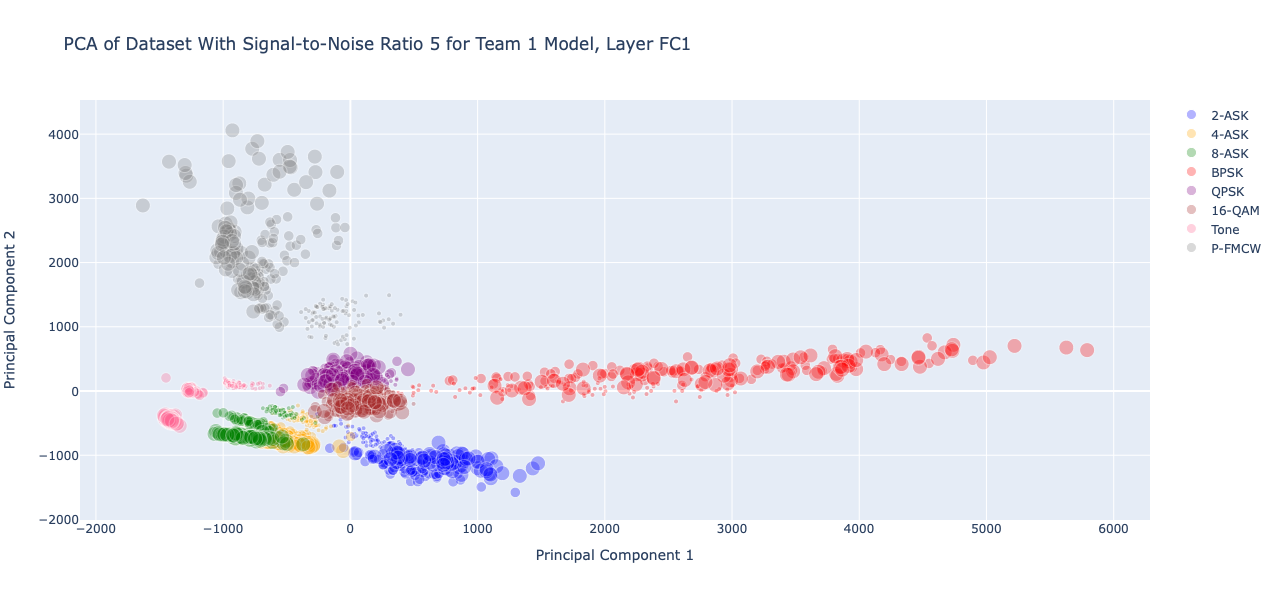

In [27]:
if PLOT_TEAM_1_MODEL:
    if 'bandwidth' in PARAMS_TO_PLOT_T1:
        for layer in LAYERS_TO_PLOT_T1:
            plot_bandwidth_feats(team1_model, getattr(team1_model, layer), BANDWIDTHS_T1, team1_test_dir, TEAM_1_OBS_INT, f'PCA of Dataset With Bandwidth {BANDWIDTHS_T1[0]} for Team 1 Model, Layer {layer.upper()}')
    if 'cent_freq' in PARAMS_TO_PLOT_T1:
        for layer in LAYERS_TO_PLOT_T1:
            plot_cent_freq_feats(team1_model, getattr(team1_model, layer), CENT_FREQS_T1, team1_test_dir, TEAM_1_OBS_INT, f'PCA of Dataset With Center Frequency {CENT_FREQS_T1[0]} for Team 1 Model, Layer {layer.upper()}')
    if 'obs_int' in PARAMS_TO_PLOT_T1:
        for layer in LAYERS_TO_PLOT_T1:
            plot_obs_int_feats(team1_model, getattr(team1_model, layer), OBS_INTS_T1, team1_test_dir, f'PCA of Dataset With Observation Interval {OBS_INTS_T1[0]} for Team 1 Model, Layer {layer.upper()}')
    if 'sig_type' in PARAMS_TO_PLOT_T1:
        for layer in LAYERS_TO_PLOT_T1:
            plot_sig_type_feats(team1_model, getattr(team1_model, layer), SIG_TYPES_T1, team1_test_dir, TEAM_1_OBS_INT, f'PCA of Dataset With Varying Signal Type for Team 1 Model, Layer {layer.upper()}')
    if 'snr' in PARAMS_TO_PLOT_T1:
        for layer in LAYERS_TO_PLOT_T1:
            plot_snr_feats(team1_model, getattr(team1_model, layer), SNRS_T1, team1_test_dir, TEAM_1_OBS_INT, f'PCA of Dataset With Signal-to-Noise Ratio {SNRS_T1[0]} for Team 1 Model, Layer {layer.upper()}')
    
if PLOT_TEAM_2_MODEL:
    if 'bandwidth' in PARAMS_TO_PLOT_T2:
        for layer in LAYERS_TO_PLOT_T2:
            plot_bandwidth_feats(team2_model, getattr(team2_model, layer), BANDWIDTHS_T2, team2_test_dir, TEAM_2_OBS_INT, f'PCA of Dataset With Bandwidth {BANDWIDTHS_T2[0]} for Team 2 Model, Layer {layer.upper()}')
    if 'cent_freq' in PARAMS_TO_PLOT_T2:
        for layer in LAYERS_TO_PLOT_T2:
            plot_cent_freq_feats(team2_model, getattr(team2_model, layer), CENT_FREQS_T2, team2_test_dir, TEAM_2_OBS_INT, f'PCA of Dataset With Center Frequency {CENT_FREQS_T2[0]} for Team 2 Model, Layer {layer.upper()}')
    if 'obs_int' in PARAMS_TO_PLOT_T2:
        for layer in LAYERS_TO_PLOT_T2:
            plot_obs_int_feats(team2_model, getattr(team2_model, layer), OBS_INTS_T2, team2_test_dir, f'PCA of Dataset With Observation Interval {OBS_INTS_T2[0]} for Team 2 Model, Layer {layer.upper()}')
    if 'sig_type' in PARAMS_TO_PLOT_T2:
        for layer in LAYERS_TO_PLOT_T2:
            plot_sig_type_feats(team2_model, getattr(team2_model, layer), SIG_TYPES_T2, team2_test_dir, TEAM_2_OBS_INT, f'PCA of Dataset With Varying Signal Type for Team 2 Model, Layer {layer.upper()}')
    if 'snr' in PARAMS_TO_PLOT_T2:
        for layer in LAYERS_TO_PLOT_T2:
            plot_snr_feats(team2_model, getattr(team2_model, layer), SNRS_T2, team2_test_dir, TEAM_2_OBS_INT, f'PCA of Dataset With Signal-to-Noise Ratio {SNRS_T2[0]} for Team 2 Model, Layer {layer.upper()}')

if PLOT_TEAM_3_MODEL:
    if 'bandwidth' in PARAMS_TO_PLOT_T3:
        for layer in LAYERS_TO_PLOT_T3:
            plot_bandwidth_feats(team3_model, getattr(team3_model, layer), BANDWIDTHS_T3, team3_test_dir, TEAM_3_OBS_INT, f'PCA of Dataset With Bandwidth {BANDWIDTHS_T3[0]} for Team 3 Model, Layer {layer.upper()}')
    if 'cent_freq' in PARAMS_TO_PLOT_T3:
        for layer in LAYERS_TO_PLOT_T3:
            plot_cent_freq_feats(team3_model, getattr(team3_model, layer), CENT_FREQS_T3, team3_test_dir, TEAM_3_OBS_INT, f'PCA of Dataset With Center Frequency {CENT_FREQS_T3[0]} for Team 3 Model, Layer {layer.upper()}')
    if 'obs_int' in PARAMS_TO_PLOT_T3:
        for layer in LAYERS_TO_PLOT_T3:
            plot_obs_int_feats(team3_model, getattr(team3_model, layer), OBS_INTS_T3, team3_test_dir, f'PCA of Dataset With Observation Interval {OBS_INTS_T3[0]} for Team 3 Model, Layer {layer.upper()}')
    if 'sig_type' in PARAMS_TO_PLOT_T3:
        for layer in LAYERS_TO_PLOT_T3:
            plot_sig_type_feats(team3_model, getattr(team3_model, layer), SIG_TYPES_T3, team3_test_dir, TEAM_3_OBS_INT, f'PCA of Dataset With Varying Signal Type for Team 3 Model, Layer {layer.upper()}')
    if 'snr' in PARAMS_TO_PLOT_T3:
        for layer in LAYERS_TO_PLOT_T3:
            plot_snr_feats(team3_model, getattr(team3_model, layer), SNRS_T3, team3_test_dir, TEAM_3_OBS_INT, f'PCA of Dataset With Signal-to-Noise Ratio {SNRS_T3[0]} for Team 3 Model, Layer {layer.upper()}')
        

if PLOT_TEAM_4_MODEL:
    if 'bandwidth' in PARAMS_TO_PLOT_T4:
        for layer in LAYERS_TO_PLOT_T4:
            plot_bandwidth_feats(team4_model, getattr(team4_model, layer), BANDWIDTHS_T4, team4_test_dir, TEAM_4_OBS_INT, f'PCA of Dataset With Varying Bandwidth for Team 4 Model, Layer {layer.upper()}')
    if 'cent_freq' in PARAMS_TO_PLOT_T4:
        for layer in LAYERS_TO_PLOT_T4:
            plot_cent_freq_feats(team4_model, getattr(team4_model, layer), CENT_FREQS_T4, team4_test_dir, TEAM_4_OBS_INT, f'PCA of Dataset With Varying Center Frequency for Team 4 Model, Layer {layer.upper()}')
    if 'obs_int' in PARAMS_TO_PLOT_T4:
        for layer in LAYERS_TO_PLOT_T4:
            plot_obs_int_feats(team4_model, getattr(team4_model, layer), OBS_INTS_T4, team4_test_dir, f'PCA of Dataset With Varying Observation Interval for Team 4 Model, Layer {layer.upper()}')
    if 'sig_type' in PARAMS_TO_PLOT_T4:
        for layer in LAYERS_TO_PLOT_T4:
            plot_sig_type_feats(team4_model, getattr(team4_model, layer), SIG_TYPES_T4, team4_test_dir, TEAM_4_OBS_INT, f'PCA of Dataset With Varying Signal Type for Team 4 Model, Layer {layer.upper()}')
    if 'snr' in PARAMS_TO_PLOT_T4:
        for layer in LAYERS_TO_PLOT_T4:
            plot_snr_feats(team4_model, getattr(team4_model, layer), SNRS_T4, team4_test_dir, TEAM_4_OBS_INT, f'PCA of Dataset With Varying Signal-to-Noise Ratio for Team 4 Model, Layer {layer.upper()}')
